In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

import pandas as pd

import os
from pathlib import Path

import datetime


In [256]:
SingerN = "JIJ"

SongN = "Wish"


In [244]:
EXPECTED_SAMPLE_RATE = 16000
MAX_ABS_INT16 = 32768.0

def convert_audio_for_model(file_path, output_file):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0
  BINS_PER_OCTAVE = 12.0
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

def index_to_time(values):
    return [x * 32 / 1000 for x in values]

def value_to_hertz(values):    
    return [0 if x==0 else output2hz(x) for x in values]

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

def Save_CSV(chng_datatime_list, outputs_pitch, file_Name):
    data ={
    'time' : chng_datatime_list,
    'pitch' : outputs_pitch
    }

    df = pd.DataFrame(data, columns=['time', 'pitch'])

    try:
        df.to_csv(file_Name)
        #file_Name 규칙은 TTP_가수명_노래명.csv
    except:
        print("CSV file save Error!!")

# 해당 부분 음정이 끊어지는 부분 알기 위해서 
def m_s_to_seconds(time_str):
    # ":"를 기준으로 분과 초를 분리하여 리스트로 저장
    minutes, seconds = time_str.split(':')
    # 분과 초를 정수형으로 변환하여 합산 후 반환
    total_seconds = int(minutes) * 60 + int(seconds)
    return total_seconds


def Show_Pitch_Plt(outputs_datetime_skip, outputs_pitch_skip):
    try:
        fig, ax = plt.subplots()
        fig.set_size_inches(25, 2)
        ax.scatter(x=outputs_datetime_skip, y=outputs_pitch_skip, s=2)
        dateFmt = mdates.DateFormatter('%M:%S')
        ax.xaxis.set_major_formatter(dateFmt)
        plt.ylim([0, 1024])     # Y축의 범위
        plt.xticks([outputs_datetime_skip[idx * 40] for idx in range(int(len(outputs_datetime_skip) / 40))])
        plt.yticks([65.4, 98.0, 130.8, 196.0, 261.6, 392.0, 523.3, 784.0])
        ax.set_yticklabels(['C2', 'G2', 'C3', 'G3', 'C4', 'G4', 'C5', 'G5'])
        plt.show()
    except:
        print("Pitch Plot Error")

def Cutting_time(outputs_datetime_skip, outputs_pitch_skip):
    befor = 0
    cut = 0

    time_set = []
    group =[]

    for i in range(len(outputs_datetime_skip)):
        time_obj = outputs_datetime_skip[i].strftime("%M:%S")
        time_obj_int = m_s_to_seconds(time_obj)
        
        befor=time_obj_int

        if(outputs_pitch_skip[i] >= 0):

            if(cut == time_obj_int-1):
                cut = time_obj_int
                group.append(time_obj)

            if(cut < time_obj_int-1):
                if(len(group) != 0):
                    time_set.append(group)
                group = []
                group.append(time_obj)
                print("here")
                cut = time_obj_int

            print(time_obj, outputs_pitch_skip[i])

    time_set.append(group)

    return time_set

In [257]:
file_path = "output/" + SingerN + "_" + SongN + "_"+"(Vocals).mp3"
output_file_path = "vocal_extract/"+SingerN+"_"+SongN+".wav"

In [258]:
convert_audio_for_model(file_path, output_file_path)
# 입력 받기 
# 첫 인자는 보컬 분리한 파일 경로
# 두 번째 인자는 wav 파일로 변환한 파일 저장할 경로+이름
# 이름 규칙 : 가수명_노래명_vocal.wav

'vocal_extract/JIJ_Wish.wav'

In [268]:
sample_rate, audio_samples = wavfile.read( "vocal_extract/"+SingerN+"_"+SongN+".wav", 'rb')
# 입력 받기
# file_name은 위에서 저장한 "경로"+file_name

In [269]:
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Total duration: {int(duration/60)}m {(duration % 60):.2f}s')
print(f'Size of the input: {len(audio_samples)}')

audio_samples = audio_samples / float(MAX_ABS_INT16)

try:
    #모델 로드
    model = hub.load("https://tfhub.dev/google/spice/2")
    print("Model load Success")
    # 오류날 경우 아래 경로로 이동
    # C:\Users\hyun9\AppData\Local\Temp\tfhub_modules
except:
    print("Model load Error")



model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

confidence_outputs = 1.0 - uncertainty_outputs

confidence_outputs = list(confidence_outputs)

pitch_outputs = [float(x) for x in pitch_outputs]

indices = range(len(pitch_outputs))
confident_pitch_outputs = [ (i, p if c >= 0.96 else 0, c) for i, p, c in zip(indices, pitch_outputs, confidence_outputs) ]
outputs_index, outputs_pitch, outputs_confident = zip(*confident_pitch_outputs)

confident_pitch_values_hz = [ output2hz(p) for p in outputs_pitch ]

output_datetime = [datetime.datetime.fromtimestamp(s) for s in index_to_time(outputs_index)]

Sample rate: 16000 Hz
Total duration: 290.27s
Total duration: 4m 50.27s
Size of the input: 4644363
Model load Success


In [270]:
chng_datatime_list = []

for date in output_datetime:
    second = (date - datetime.datetime(1970, 1, 1, 9)).total_seconds()
    chng_datatime_list.append(second)
#print("초로 변환된 값:", seconds_since_epoch)

pitch_data_list = []

for time, pitch in zip(chng_datatime_list, outputs_pitch):
    pitch_data_list.append([time, pitch])

In [271]:
o=[]
for time, pitch in zip(chng_datatime_list, outputs_pitch):
    if (pitch >= 0.6):
        o.append(0)
    else:
        o.append(pitch)

print(o)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5563538074493408, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [272]:
outputs_pitch = o

In [273]:
CSV_file_Name = "CSV/TTP_"+SingerN+"_"+SongN+".csv"

In [274]:
Save_CSV(chng_datatime_list, outputs_pitch, CSV_file_Name)
# 입력 받기
# file_Name 규칙은 다음과 같음
# file_Name 규칙은 TTP_가수명_노래명.csv

In [275]:
outputs_index_skip = []
outputs_pitch_func = zero_to_nan(value_to_hertz(outputs_pitch))
outputs_pitch_skip = []
outputs_datetime_skip = []

#5개 pitch 값 합치는 코드 

for i in range(int(len(outputs_pitch_func) / 5)):
    print(i)
    outputs_index_skip.append(i)
    outputs_pitch_skip.append(np.nanmean(outputs_pitch_func[i*5:i*5+5]))
    outputs_datetime_skip.append(datetime.datetime.fromtimestamp(i * 32 * 5 / 1000))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\hyun9\AppData\Local\Temp\ipykernel_1460\2240091187.py:11: RuntimeWarning: Mean of empty slice
  outputs_pitch_skip.append(np.nanmean(outputs_pitch_func[i*5:i*5+5]))


In [276]:
tiem_set_list = Cutting_time(outputs_datetime_skip, outputs_pitch_skip)

here
00:07 332.61228562215615
here
00:14 113.46327979657258
00:14 120.47373858468525
00:14 131.5095030379891
00:14 145.173682274145
00:14 146.75304514635638
00:14 146.9242045685819
00:15 164.32436628957663
00:15 165.23531399443732
00:15 162.38843846968211
00:15 163.56420118097572
00:15 160.71436374759344
00:15 164.1493992884919
00:16 196.4645016782536
00:16 194.78137843321647
00:16 195.57068985148473
00:16 196.66884751240514
00:17 193.6151019605851
00:17 180.1004601847196
00:17 174.5141043600191
00:17 174.81458425793892
00:17 174.9975980501856
00:18 199.111963652772
00:18 206.03461323918782
00:18 218.24468745811248
00:18 192.00396775076874
00:18 195.61327996774867
00:19 195.40230842500588
00:19 113.09420733930531
00:20 114.6048192969326
00:20 122.38110803175786
00:20 131.02341493336647
00:20 130.79363731384103
00:20 129.4721065480308
00:20 129.00928580529066
00:20 130.40847612010919
00:21 118.47510116449281
00:21 131.1588981747273
00:21 142.25082270705445
00:22 156.72131799483697
00:22

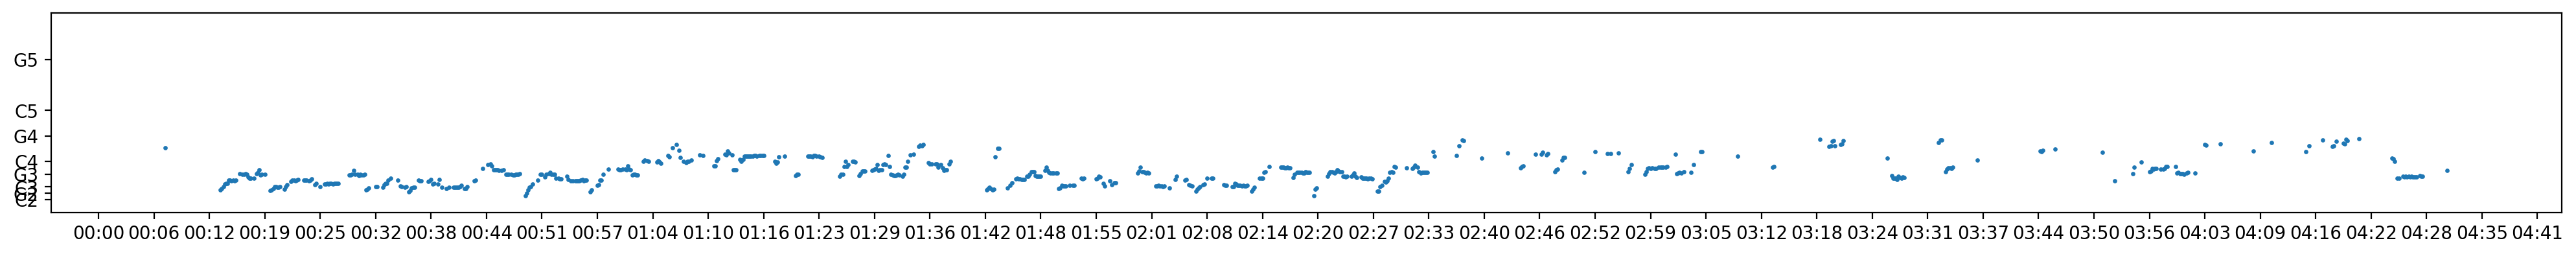

In [277]:
Show_Pitch_Plt(outputs_datetime_skip, outputs_pitch_skip)

In [278]:
indices = range(len(pitch_outputs))
confident_pitch_outputs = [ (i, p if c >= 0.96 else 0, c) for i, p, c in zip(indices, pitch_outputs, confidence_outputs) ]
outputs_index, outputs_pitch, outputs_confident = zip(*confident_pitch_outputs)

final_outputs = [ (i, t, p) for i, t, p in zip(outputs_index, index_to_time(outputs_index), value_to_hertz(outputs_pitch)) ]

df=pd.DataFrame(final_outputs, columns=['index', 'time', 'pitch_point'])

# 우리가 실제로 보여줄 pitch 값들 저장하는 코드 
# 파일명은 다음과 같이 지정함
# output_가수명_음악명.xlsx

Xlsx_file_Name = "Xlsx/"+SingerN+"_"+SongN+".xlsx"

print(Xlsx_file_Name)

try:
    df.to_excel(Xlsx_file_Name, sheet_name='output')
except:
    print("Error")

Xlsx/JIJ_Wish.xlsx
